In [1]:
import gymnasium as gym
import os
import matplotlib.pyplot as plt
import json # for dumping debug data
import time # for benchmarking
import numpy as np
from ddqn_torch import DoubleQAgent

In [2]:
LEARN_EVERY = 4
def train_agent(n_episodes=2000, load_latest_model=False):
    print("Training a DDQN agent on {} episodes. Pretrained model = {}".format(n_episodes,load_latest_model))
    env = gym.make("LunarLander-v2")
    agent = DoubleQAgent(gamma=0.99, epsilon=1.0, epsilon_dec=0.995, lr=0.001, mem_size=200000, batch_size=512, epsilon_end=0.01)
    if load_latest_model:
        agent.load_saved_model('ddqn_torch_model.h5')
        print('Loaded most recent: ddqn_torch_model.h5')
        
    scores = []
    eps_history = []
    score_list = []
    avg_score_list = []

    start = time.time()
    for i in range(n_episodes):
        terminated = False
        truncated = False
        score = 0
        state = env.reset()[0]
        steps = 0
        while not (terminated or truncated):
            action = agent.choose_action(state)
            new_state, reward, terminated, truncated, info = env.step(action)
            agent.save(state, action, reward, new_state, terminated)
            state = new_state
            if steps > 0 and steps % LEARN_EVERY == 0:
                agent.learn()
            steps += 1
            score += reward
            
        eps_history.append(agent.epsilon)
        scores.append(score)
        avg_score = np.mean(scores[max(0, i-100):(i+1)])

        score_list.append(score)
        avg_score_list.append(avg_score)

        if (i+1) % 10 == 0 and i > 0:
            # Report expected time to finish the training
            print('Episode {} in {:.2f} min. Expected total time for {} episodes: {:.0f} min. [{:.2f}/{:.2f}]'.format((i+1), 
                                                                                                                      (time.time() - start)/60, 
                                                                                                                      n_episodes, 
                                                                                                                      (((time.time() - start)/i)*n_episodes)/60, 
                                                                                                                      score, 
                                                                                                                      avg_score))
            
        if (i+1) % 100 == 0 and i > 0:
            # Save the model every N-th step just in case
            agent.save_model('ddqn_torch_model.h5')
            with open("ddqn_torch_dqn_scores_{}.json".format(int(time.time())), "w") as fp:
                json.dump(scores, fp)
            with open("ddqn_torch_eps_history_{}.json".format(int(time.time())), "w") as fp:
                json.dump(eps_history, fp)
                
    return agent, score_list, avg_score_list

In [3]:
#Train
agent, score_list, avg_score_list = train_agent(n_episodes=1500, load_latest_model=False)

Training a DDQN agent on 1500 episodes. Pretrained model = False
Episode 10 in 0.02 min. Expected total time for 1500 episodes: 4 min. [-450.57/-227.03]
Episode 20 in 0.19 min. Expected total time for 1500 episodes: 15 min. [12.59/-231.94]
Episode 30 in 0.61 min. Expected total time for 1500 episodes: 32 min. [-9.37/-212.72]
Episode 40 in 1.10 min. Expected total time for 1500 episodes: 42 min. [-88.38/-185.86]
Episode 50 in 1.69 min. Expected total time for 1500 episodes: 52 min. [-116.04/-165.98]
Episode 60 in 1.98 min. Expected total time for 1500 episodes: 50 min. [10.40/-156.75]
Episode 70 in 2.35 min. Expected total time for 1500 episodes: 51 min. [-133.38/-154.34]
Episode 80 in 2.79 min. Expected total time for 1500 episodes: 53 min. [-77.17/-142.05]
Episode 90 in 3.41 min. Expected total time for 1500 episodes: 57 min. [-107.60/-133.42]
Episode 100 in 4.03 min. Expected total time for 1500 episodes: 61 min. [-74.95/-127.40]
Episode 110 in 4.64 min. Expected total time for 1500 

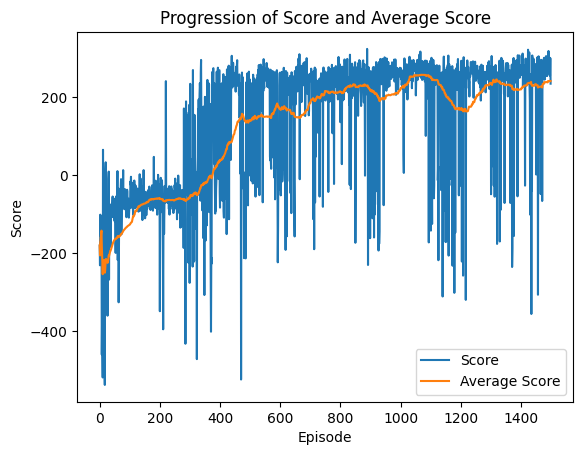

In [4]:
import matplotlib.pyplot as plt

# Plot the progression of score_list and avg_score_list in the same plot

plt.plot(score_list, label='Score')
plt.plot(avg_score_list, label='Average Score')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Progression of Score and Average Score')
plt.legend()
plt.show()

In [8]:
import gymnasium as gym
import os
import matplotlib.pyplot as plt
import imageio

# Set path to the model to visualize
model_to_animate = 'ddqn_torch_model.h5'

def animate_model(name, atype='single', save_gif_name='animation.gif'):
    env = gym.make("LunarLander-v2", render_mode="rgb_array")
    agent = DoubleQAgent(gamma=0.99, epsilon=0.0, lr=0.0005, mem_size=200000, batch_size=64, epsilon_end=0.01)
    agent.load_saved_model(name)
    state, info = env.reset()
    frames = []  # To store frames for the GIF
    for _ in range(5):
        terminated = False
        truncated = False
        while not (terminated or truncated):
            action = agent.choose_action(state)
            new_state, reward, terminated, truncated, info = env.step(action)
            state = new_state
            
            # Capture the current frame
            frames.append(env.render())
            
            if terminated or truncated:
                break  # Exit the loop if the episode is done

        state, info = env.reset()  # Reset the environment for the next episode

    env.close()
    
    # Save the frames as a GIF
    imageio.mimsave(save_gif_name, frames, fps=30)  # Adjust fps to control the speed of the GIF

animate_model(model_to_animate, atype='double', save_gif_name='ddqn_lunar_lander_no_seed.gif')
